In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns
import openfermion

import numpy as np

import pennylane as qml
from pennylane import expval

In [2]:
dev = qml.device("default.qubit", wires=2)

In [3]:
alpha = 0.4
beta = 0.2

coeffs = [alpha, alpha, beta]
obs_list = [
    qml.PauliZ(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1)
]

In [4]:
def circuit(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    
    qml.CNOT(wires=wires)
    
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])

In [5]:
qnodes = qml.map(circuit, obs_list, dev, measure='expval')
energy_expval = qml.dot([alpha, alpha, beta], qnodes)

Number of VQE runs

In [6]:
k_runs = 30

In [7]:
step_size = 0.3
max_iterations = 20

Here, we don't terminate based on energy improvement but run a fixed number of steps (50 in this case). 

In [13]:
# Lists to store energy histories for all the VQE runs
energy_history_QNG = []
energy_history_QNG_diag = []
energy_history_vanilla = []

#comparing 3 different optimizers 
optimizers = ['QNG', 'QNG_diag', 'Vanilla']

'''

so that we can use the same initial params for all the optimizers, i created all the 
params randomly outside the loop, and then just assigned the inital params inside the loop by 
using the k'th index according to each run. that way we compare all runs according to the same params
for each run / optimizer.

'''

param_trials = []

for i in range(k_runs):
    params = np.random.uniform(low=0, high=2*np.pi, size=4).tolist()
    param_trials.append(params)

for l in optimizers:
    
    if l == 'QNG':
        print("QUANTUM NATURAL GRADIENT")
    
        for k in range(k_runs):

            # Energy history for a single VQE run
            energy_history_single_run_QNG = []

            # initialize parameters based on param_trials created above
            initial_params = param_trials[k]

            params = initial_params
            prev_energy = energy_expval(params)
            energy_history_single_run_QNG.append(prev_energy)

            for n in range(max_iterations):

                grad_cost = qml.grad(energy_expval, argnum=[0])
                grad_at_point = [float(i) for i in grad_cost(params)[0]] 

                params = params - step_size * np.dot(np.linalg.pinv(qnodes[0].metric_tensor([params])),
                                                     grad_at_point)

                energy = energy_expval(params)

                conv = np.abs(energy - prev_energy)

                prev_energy = energy
                energy_history_single_run_QNG.append(prev_energy)

            if k % 10 == 0:
                print('Finished run #{}'.format(k))

            energy_history_single_run_QNG = np.array(energy_history_single_run_QNG)

            energy_history_QNG.append(energy_history_single_run_QNG)

            
    if l == 'QNG_diag':
        print("QUANTUM NATURAL GRADIENT, DIAG. APPROX.")

        for k in range(k_runs):

            energy_history_single_run_QNG_diag = []

            initial_params = param_trials[k]

            params = initial_params
            prev_energy = energy_expval(params)
            energy_history_single_run_QNG_diag.append(prev_energy)

            for n in range(max_iterations):

                grad_cost = qml.grad(energy_expval, argnum=[0])
                grad_at_point = [float(i) for i in grad_cost(params)[0]] 

                params = params - step_size * np.dot(np.linalg.pinv(qnodes[0].metric_tensor([params], diag_approx='True'),),
                                                     grad_at_point)

                energy = energy_expval(params)

                conv = np.abs(energy - prev_energy)

                prev_energy = energy
                energy_history_single_run_QNG_diag.append(prev_energy)
                
                

            if k % 10 == 0:
                print('Finished run #{}'.format(k))

            energy_history_single_run_QNG_diag = np.array(energy_history_single_run_QNG_diag)
            
            energy_history_QNG_diag.append(energy_history_single_run_QNG_diag)
            
    if l == 'Vanilla':
        print("VANILL GRADIENT DESCENT")

        for k in range(k_runs):

            energy_history_single_run_vanilla = []

            initial_params = param_trials[k]

            params = initial_params
            prev_energy = energy_expval(params)
            energy_history_single_run_vanilla.append(prev_energy)

            for n in range(max_iterations):

                grad_cost = qml.grad(energy_expval, argnum=[0])
                grad_at_point = [float(i) for i in grad_cost(params)[0]] 

                params = params - np.dot(step_size, grad_at_point)

                energy = energy_expval(params)

                conv = np.abs(energy - prev_energy)

                prev_energy = energy
                energy_history_single_run_vanilla.append(prev_energy)

            if k % 10 == 0:
                print('Finished run #{}'.format(k))

            energy_history_single_run_vanilla = np.array(energy_history_single_run_vanilla)
            
            energy_history_vanilla.append(energy_history_single_run_vanilla)



QUANTUM NATURAL GRADIENT
Finished run #0
Finished run #10
Finished run #20
QUANTUM NATURAL GRADIENT, DIAG. APPROX.
Finished run #0
Finished run #10
Finished run #20
VANILL GRADIENT DESCENT
Finished run #0
Finished run #10
Finished run #20


QNG


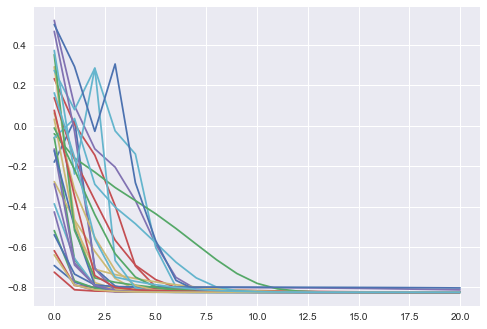

QNG DIAG APPROX


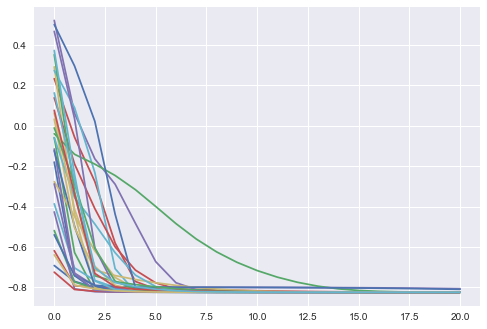

VANILLA


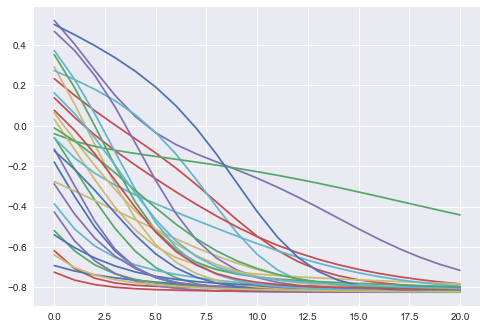

In [14]:
for i in range(k_runs):
    plt.plot(energy_history_QNG[i])

print("QNG")
plt.show()

for i in range(k_runs):
    plt.plot(energy_history_QNG_diag[i])


print("QNG DIAG APPROX")
plt.show()

for i in range(k_runs):
    plt.plot(energy_history_vanilla[i])


print("VANILLA")
plt.show()



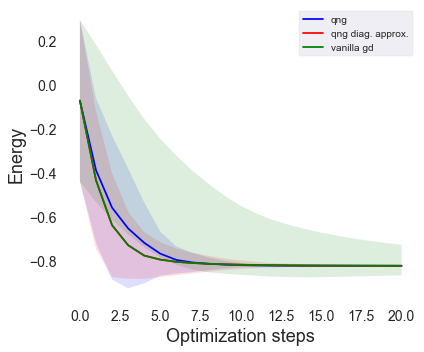

In [15]:
%matplotlib inline
plt.style.use("seaborn")
fig = plt.figure(figsize=(6, 5))

ax = plt.axes()
ax.set_facecolor("white")

'''    PLOTTING STD ---- QNG   '''


#needs to be an array for .mean() and .std() to work for some reason
energy_hist_QNG = np.asarray(energy_history_QNG)

#x values (optimization steps)
x = np.arange(max_iterations+1)

#calc standard dev. and mean
std_qng = energy_hist_QNG.std(axis=0)
mean_qng = energy_hist_QNG.mean(axis=0)

#plot mean for reference
plt.plot(mean_qng, color='blue', label='qng')

#plot x values, and fill to +- standard dev
plt.fill_between(x, mean_qng-std_qng, mean_qng+std_qng, facecolor='blue', alpha=0.13)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Energy", fontsize=18)
plt.xlabel("Optimization steps", fontsize=18)

plt.tight_layout()

#plt.show()


'''    PLOTTING STD -- QNG_DIAG_APP  '''


energy_hist_QNG_diag = np.asarray(energy_history_QNG_diag)


x = np.arange(max_iterations+1)

std_qng_diag = energy_hist_QNG_diag.std(axis=0)
mean_qng_diag = energy_hist_QNG_diag.mean(axis=0)

plt.plot(mean_qng_diag, color='red', label='qng diag. approx.')


plt.fill_between(x, mean_qng_diag-std_qng_diag, mean_qng_diag+std_qng_diag, facecolor='red', alpha=0.13)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Energy", fontsize=18)
plt.xlabel("Optimization steps", fontsize=18)


'''    PLOTTING STD -- VANILLA GD  '''


energy_hist_vanilla = np.asarray(energy_history_vanilla)


x = np.arange(max_iterations+1)


std_vanilla = energy_hist_vanilla.std(axis=0)
mean_vanilla = energy_hist_vanilla.mean(axis=0)


plt.plot(mean_qng_diag, color='green', label='vanilla gd')


plt.fill_between(x, mean_vanilla-std_vanilla, mean_vanilla+std_vanilla, facecolor='green', alpha=0.13,)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Energy", fontsize=18)
plt.xlabel("Optimization steps", fontsize=18)


plt.tight_layout()
ax. legend(loc='upper right', frameon=True)
plt.show()


